# Import Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, transforms

import timm
import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
!nvidia-smi

Sat Jun  8 01:51:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              26W / 250W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Load Data

In [4]:
batch_size = 64
img_size = 224
model_type = 'all-62k'

data_dir = '/kaggle/input/skin-augmented-62k/augmented_62k'

In [5]:
for folder in os.listdir(data_dir):
    print(folder, len(os.listdir(os.path.join(data_dir, folder))))

A5_미란_궤양 62097
A2_비듬_각질_상피성잔고리 62097
A1_구진_플라크 62097
A6_결절_종괴 62097
A3_태선화_과다색소침착 62097
A4_농포_여드름 62097
A7_무증상 62097


In [6]:
from torchvision.transforms import (
    Compose,
    ToTensor
)

transforms = Compose(
        [
            ToTensor()
        ]
    )

In [7]:
dataset = datasets.ImageFolder(data_dir, transforms)

In [8]:
torch.manual_seed(42)

train_size = int(len(dataset)*0.8)
valid_size = len(dataset) - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
labels = dataset.classes
num_classes = len(labels)
labels

['A1_구진_플라크',
 'A2_비듬_각질_상피성잔고리',
 'A3_태선화_과다색소침착',
 'A4_농포_여드름',
 'A5_미란_궤양',
 'A6_결절_종괴',
 'A7_무증상']

In [9]:
print(len(train_dataset), len(valid_dataset))

347743 86936


# Model Training

In [10]:
# inception_v4 1536 
# inception_resnet_v2 1536
# resnet50 2048 
# resnetv2_50 2048
# efficientnet_b0
# vit_base_resnet50_224_in21k 
# vit_base_patch16_224 768
# vit_base_patch8_224 768
# efficientvit_b0
# vit_tiny_patch16_224

In [11]:
model_name = 'efficientvit_b0'
hidden_size = 640
pretrained = True
model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)

model.safetensors:   0%|          | 0.00/13.7M [00:00<?, ?B/s]

In [12]:
def calc_accuracy(X, Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [13]:
from IPython.display import clear_output

def loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch):

  figure, ax = plt.subplots(1, 2, figsize=(12, 5))

  ax[0].plot(train_loss_epoch)
  ax[0].plot(val_loss_epoch)
  ax[0].set_title('Loss-Epoch curve')
  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel('Epoch')
  ax[0].legend(['train', 'val'], loc='upper right')

  ax[1].plot(train_acc_epoch)
  ax[1].plot(val_acc_epoch)
  ax[1].set_title('Model Accuracy')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_xlabel('Epoch')
  ax[1].legend(['train', 'val'], loc='lower right')

  plt.show()

In [14]:
class Classifier(nn.Module):
    def __init__(self, model, hidden_size, num_classes=2): 
        super().__init__()
        self.model = model
        self.classifier = nn.Linear(hidden_size, num_classes)
        # self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x # self.sigmoid(x)

In [15]:
# classifier = Classifier(model, hidden_size, num_classes=num_classes)
classifier = model.to(device)

In [16]:
opt_name = 'AdamW'
# optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001) # correct_bias=False # Adam
optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.01, weight_decay=1e-5) #, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                          factor=0.5, patience=2)
loss_fn = nn.CrossEntropyLoss()

In [17]:
from collections import OrderedDict
import pickle

def save_checkpoint(epoch, labels, model, optimizer, lr_scheduler,
                    train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch, lr_epoch,
                    model_path, filename):
    
    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'label': labels
    }
    torch.save(state, os.path.join(model_path, f'{filename}.pt'))

    config = {"train":{"acc":train_acc_epoch, "loss":train_loss_epoch},
              "valid":{"acc":val_acc_epoch, "loss":val_loss_epoch},
              "lr": lr_epoch}

    with open(os.path.join(model_path, f'{filename}.pickle'),'wb') as fw:
        pickle.dump(config, fw)

In [18]:
model_path = f'/kaggle/working/{model_type}'
os.makedirs(model_path, exist_ok=True)

In [19]:
def load_dict(model, optimizer, lr_scheduler, dict_file):
    
    pretrained = torch.load(dict_file)
    
    epoch = pretrained['epoch']
    state_dict = pretrained['state_dict']
    opt_dict = pretrained['optimizer']
    sch_dict = pretrained['lr_scheduler']
    labels = pretrained['label']
    
    model_dict = model.state_dict()
    model_dict.update(state_dict)
    model.load_state_dict(model_dict)
    
    optimizer.load_state_dict(opt_dict)
    lr_scheduler.load_state_dict(sch_dict)
    
    return epoch, labels, model, optimizer, lr_scheduler

In [20]:
import pickle
def load_records(pkl_file):
    with open(pkl_file, 'rb') as f:
        records = pickle.load(f)
    return records['train'], records['valid'], records['lr']

In [21]:
file_path = '/kaggle/input/skin-augmented-62k'

pretrained = True

In [22]:
num_epochs = 40

best_val_acc, best_val_loss = 0.0, 100.0

lr_epoch = []
train_loss_epoch, val_loss_epoch = [], []
train_acc_epoch, val_acc_epoch = [], []
epoch_start = 0

classifier = classifier.to(device)

if pretrained:
    dict_file = os.path.join(file_path, f'{model_name}_{opt_name}.pt')
    pkl_file = os.path.join(file_path, f'{model_name}_{opt_name}.pickle')
    
    epoch_start, labels, classifier, optimizer, lr_scheduler = load_dict(classifier, optimizer, lr_scheduler, dict_file)
    train_epoch, valid_epoch, lr_epoch = load_records(pkl_file)
    train_loss_epoch, train_acc_epoch = train_epoch['loss'], train_epoch['acc']
    val_loss_epoch, val_acc_epoch = valid_epoch['loss'], valid_epoch['acc']
    best_val_acc, best_val_loss = max(val_acc_epoch), min(val_loss_epoch)

In [23]:
print(epoch_start, best_val_acc, best_val_loss)

10 0.5372401582045622 1.2283892910475236


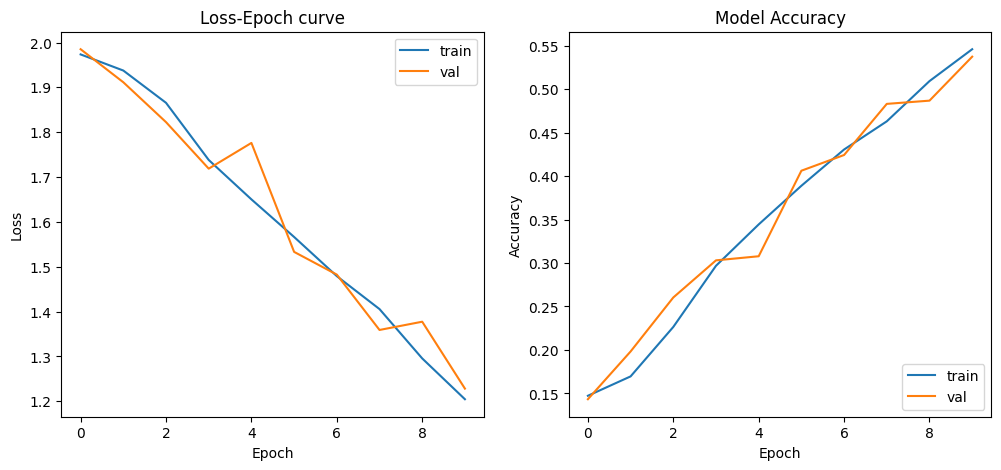

In [24]:
loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch)

epoch 36 train acc 0.836316127102948 validation acc 0.7581133492764288


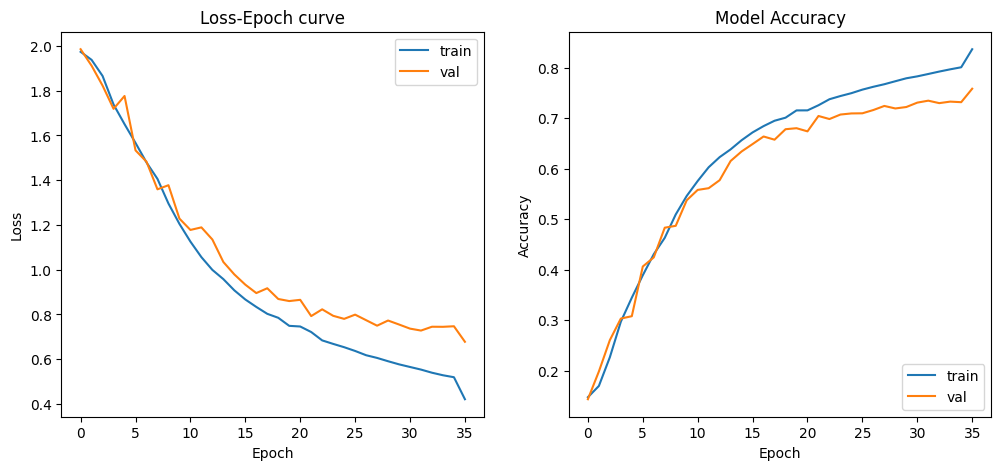

  0%|          | 0/5434 [00:00<?, ?it/s]

epoch 37 train acc 0.8445775627174185 loss 0.3993534368212977


  0%|          | 0/1359 [00:00<?, ?it/s]

epoch 37 valid acc 0.7572778697571744 loss 0.7024578361102463


  0%|          | 0/5434 [00:00<?, ?it/s]

epoch 38 train acc 0.850451848130647 loss 0.3852949076039764


  0%|          | 0/1359 [00:00<?, ?it/s]

epoch 38 valid acc 0.7543805187637969 loss 0.7164383493226797


  0%|          | 0/5434 [00:00<?, ?it/s]

epoch 39 train acc 0.853553677858644 loss 0.37555699914907725


  0%|          | 0/1359 [00:00<?, ?it/s]

epoch 39 valid acc 0.7574733259749816 loss 0.7106679434106138


  0%|          | 0/5434 [00:00<?, ?it/s]

epoch 40 train acc 0.8748014109193014 loss 0.3201985377722369


  0%|          | 0/1359 [00:00<?, ?it/s]

epoch 40 valid acc 0.7658817758155506 loss 0.7325481939855264


  0%|          | 0/5434 [00:00<?, ?it/s]

epoch 41 train acc 0.8810661961128854 loss 0.304205557248491


  0%|          | 0/1359 [00:00<?, ?it/s]

epoch 41 valid acc 0.7689400907530046 loss 0.7217786803874485


  0%|          | 0/5434 [00:00<?, ?it/s]

epoch 42 train acc 0.8826728105298777 loss 0.29863196905711953


  0%|          | 0/1359 [00:00<?, ?it/s]

epoch 42 valid acc 0.7678133431444689 loss 0.7453200672372814


  0%|          | 0/5434 [00:00<?, ?it/s]

epoch 43 train acc 0.8955496567312144 loss 0.2671862554228784


  0%|          | 0/1359 [00:00<?, ?it/s]

epoch 43 valid acc 0.7692198614177091 loss 0.7693763023531551


  0%|          | 0/5434 [00:00<?, ?it/s]

epoch 44 train acc 0.8983274922233964 loss 0.25925263047100405


  0%|          | 0/1359 [00:00<?, ?it/s]

epoch 44 valid acc 0.7694229825852342 loss 0.7745638137533877


  0%|          | 0/5434 [00:00<?, ?it/s]

epoch 45 train acc 0.9002110739430349 loss 0.25347101693937985


  0%|          | 0/1359 [00:00<?, ?it/s]

epoch 45 valid acc 0.7691355469708118 loss 0.7875020929980225


  0%|          | 0/5434 [00:00<?, ?it/s]

epoch 46 train acc 0.9066027483764114 loss 0.2372211643498436


  0%|          | 0/1359 [00:00<?, ?it/s]

epoch 46 valid acc 0.7703657714005395 loss 0.8070498012921844


  0%|          | 0/5434 [00:00<?, ?it/s]

epoch 47 train acc 0.9079860080496753 loss 0.2333231159411494


  0%|          | 0/1359 [00:00<?, ?it/s]

epoch 47 valid acc 0.7689439232278636 loss 0.8152862053701683


  0%|          | 0/5434 [00:00<?, ?it/s]

epoch 48 train acc 0.9090299688639035 loss 0.2307369068105913


  0%|          | 0/1359 [00:00<?, ?it/s]

epoch 48 valid acc 0.7702507971547706 loss 0.8347431106041949


  0%|          | 0/5434 [00:00<?, ?it/s]

epoch 49 train acc 0.9124339025787456 loss 0.2224276087339042


  0%|          | 0/1359 [00:00<?, ?it/s]

epoch 49 valid acc 0.7699710264900662 loss 0.840616024838729


  0%|          | 0/5434 [00:00<?, ?it/s]

epoch 50 train acc 0.9138924795493132 loss 0.21908957354126607


  0%|          | 0/1359 [00:00<?, ?it/s]

epoch 50 valid acc 0.7700515084621045 loss 0.8478212344835049


In [25]:
for e in range(epoch_start+1, num_epochs+epoch_start+1):
    train_acc, train_loss = 0.0, 0.0
    val_acc, val_loss = 0.0, 0.0
    classifier.train()
    
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4,
                                          pin_memory=True)

    valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4,
                                          pin_memory=True)

    for batch_id, batch in enumerate(tqdm.notebook.tqdm(train_loader)):
        optimizer.zero_grad()

        img = batch[0].to(device)
        label = batch[1].to(device) # .squeeze(1) .float()

        out = classifier(img).squeeze(1)
        loss = loss_fn(out, label)

        train_loss += loss.item()
        loss.backward()

        optimizer.step()

        train_acc += calc_accuracy(out, label)

    tot_train_acc = train_acc / (batch_id+1)
    mean_train_loss = train_loss / (batch_id+1)
    train_loss_epoch.append(mean_train_loss)
    train_acc_epoch.append(tot_train_acc)
    lr = optimizer.param_groups[0]['lr']
    lr_epoch.append(lr)
    print("epoch {} train acc {} loss {}".format(e, tot_train_acc, mean_train_loss))

    classifier.eval()
    with torch.no_grad():
        for batch_id, batch in enumerate(tqdm.notebook.tqdm(valid_loader)):

            img = batch[0].to(device)
            label = batch[1].to(device) # .squeeze(1)

            out = classifier(img).squeeze(1)
            loss = loss_fn(out, label)
            val_loss += loss.item()
            val_acc += calc_accuracy(out, label)
        
    tot_acc = val_acc / (batch_id+1)
    mean_val_loss = val_loss / (batch_id+1)
    lr_scheduler.step(mean_val_loss)
    
    val_loss_epoch.append(mean_val_loss)
    val_acc_epoch.append(tot_acc)
    print("epoch {} valid acc {} loss {}".format(e, tot_acc, mean_val_loss))
    if best_val_loss > mean_val_loss:
      clear_output(wait=True)
      print("epoch {} train acc {} validation acc {}".format(e, tot_train_acc, tot_acc))
      loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch)
      best_val_loss = mean_val_loss
      save_checkpoint(e, labels, classifier, optimizer, lr_scheduler,
                      train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch, lr_epoch,
                      model_path, f'{model_name}_{opt_name}')

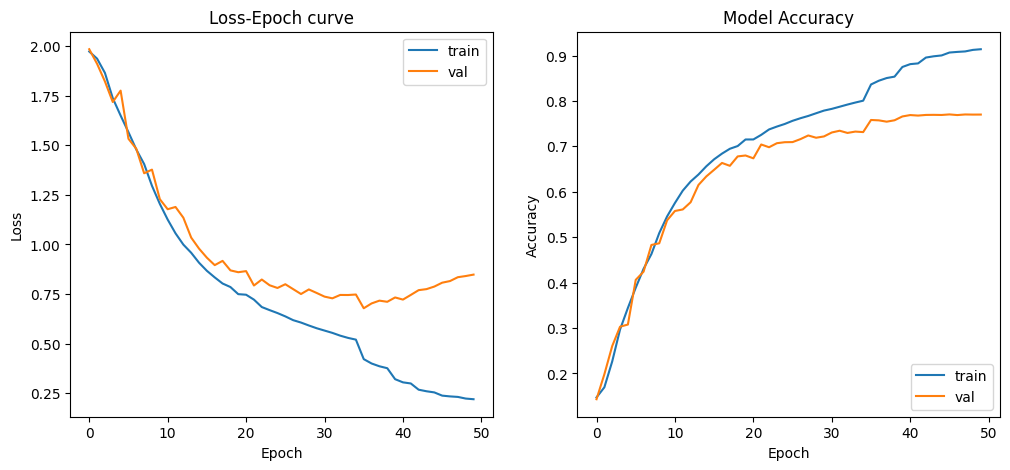

In [26]:
loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch)

In [27]:
save_checkpoint(e, labels, classifier, optimizer, lr_scheduler,
                train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch, lr_epoch,
                model_path, f'{model_name}_{opt_name}_{e}epoch')

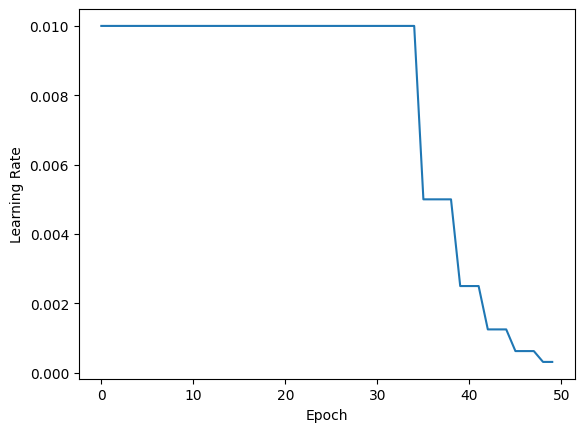

In [28]:
plt.plot(lr_epoch)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()

# to .onnx

In [29]:
dict_file = os.path.join(model_path, f'{model_name}_{opt_name}.pt')

pretrained = torch.load(dict_file)

state_dict = pretrained['state_dict']
labels = pretrained['label']

model_dict = classifier.state_dict()
model_dict.update(state_dict)
classifier.load_state_dict(model_dict)

<All keys matched successfully>

In [30]:
classifier = classifier.to(device)
classifier.eval()

EfficientVit(
  (stem): Stem(
    (in_conv): ConvNormAct(
      (dropout): Dropout(p=0.0, inplace=False)
      (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): Hardswish()
    )
    (res0): ResidualBlock(
      (pre_norm): Identity()
      (main): DSConv(
        (depth_conv): ConvNormAct(
          (dropout): Dropout(p=0.0, inplace=False)
          (conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
          (norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): Hardswish()
        )
        (point_conv): ConvNormAct(
          (dropout): Dropout(p=0.0, inplace=False)
          (conv): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act):

In [31]:
labels

['A1_구진_플라크',
 'A2_비듬_각질_상피성잔고리',
 'A3_태선화_과다색소침착',
 'A4_농포_여드름',
 'A5_미란_궤양',
 'A6_결절_종괴',
 'A7_무증상']

In [32]:
import torch.onnx

In [33]:
torch_input = torch.randn(1, 3, 224, 224).to(device)
torch.onnx.export(classifier, torch_input, os.path.join(model_path, f'{model_name}_{opt_name}.onnx'))

/opt/conda/lib/python3.10/site-packages/torch/onnx/_internal/jit_utils.py:307: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at /usr/local/src/pytorch/torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/opt/conda/lib/python3.10/site-packages/torch/onnx/utils.py:702: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at /usr/local/src/pytorch/torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_graph_shape_type_inference(
/opt/conda/lib/python3.10/site-packages/torch/onnx/utils.py:1209: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at /usr/local/src/pytorch/torch/csrc/jit/passes/onnx

# Inference

In [34]:
def inference(img_path):

    img = Image.open(img_path)
    img = img.resize((224, 224))
    img = ToTensor()(img).unsqueeze(0).to(device)

    outputs = classifier(img)
    result = outputs.softmax(1)
    
    return (result[0].argmax(), result[0].tolist())

In [35]:
root = '/kaggle/input/dog-skin/test_dog_resized/test_dog_resized'

predictions = {'target':[], 'pred':[], 'probs':[]}
for folder in os.listdir(root):
    print(folder, len(os.listdir(os.path.join(root, folder))))
    for file in os.listdir(os.path.join(root, folder)):
        predictions['target'].append(folder)
        inf_result = inference(os.path.join(root, folder, file))
        predictions['pred'].append(labels[inf_result[0]])
        predictions['probs'].append(inf_result[1])
        if len(predictions['pred']) % 1000 == 0:
            print(len(predictions['pred']), "done")

무증상 17401
1000 done
2000 done
3000 done
4000 done
5000 done
6000 done
7000 done
8000 done
9000 done
10000 done
11000 done
12000 done
13000 done
14000 done
15000 done
16000 done
17000 done
A5_미란_궤양 1500
18000 done
A2_비듬_각질_상피성잔고리 7849
19000 done
20000 done
21000 done
22000 done
23000 done
24000 done
25000 done
26000 done
A1_구진_플라크 4068
27000 done
28000 done
29000 done
30000 done
A6_결절_종괴 1514
31000 done
32000 done
A3_태선화_과다색소침착 6746
33000 done
34000 done
35000 done
36000 done
37000 done
38000 done
39000 done
A4_농포_여드름 1668
40000 done


In [36]:
import json

with open(os.path.join(model_path, f'{model_type}_{model_name}_{opt_name}.json'), 'w') as f:
    json.dump(predictions, f)

ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of labels (7).

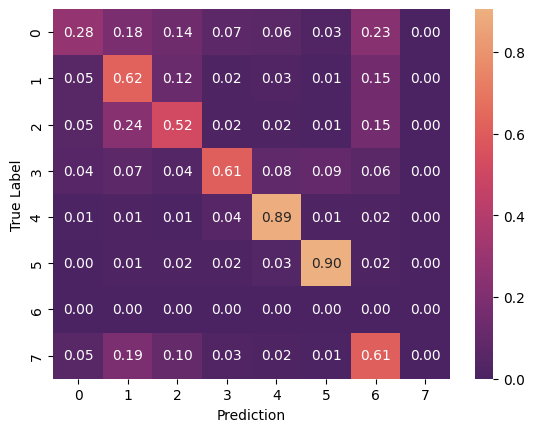

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

codes = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7']

cm = confusion_matrix(predictions['target'], predictions['pred'], normalize='true')
hm = sns.heatmap(cm, annot=True, fmt='.2f', cmap='flare_r')
hm.set_xlabel('Prediction', fontsize=10)
hm.set_ylabel('True Label', fontsize=10)
hm.set_xticklabels(labels=codes, fontsize=10)
hm.set_yticklabels(labels=codes, fontsize=10, rotation=0)

In [ ]:
from sklearn.metrics import classification_report

cr = classification_report(predictions['target'], predictions['pred'])
print(cr)